In [1]:
import pandas as pd
pd.__version__

'2.2.2'

In [2]:
import transformers
transformers.__version__

'4.44.2'

In [3]:
!pip install bertviz # to visualize bert
!pip install umap-learn # similar algorithm like t-SNE for dimensionality reduction
!pip install datasets # feature of huggingface to directly access (download and pre-process) 221k+ datasets present in huggingface datasets hub
!pip install accelerate # feature of huggingface for pytorch users to write and maintain the boilerplate code needed to use multi-GPUs/TPU/fp16

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 705.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00


In [4]:
import pandas as pd

df = pd.read_csv("/content/twitter_multi_class_sentiment.csv")
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [6]:
df.label.value_counts(), df.label_name.value_counts()

(label
 1    5362
 0    4666
 3    2159
 4    1937
 2    1304
 5     572
 Name: count, dtype: int64,
 label_name
 joy         5362
 sadness     4666
 anger       2159
 fear        1937
 love        1304
 surprise     572
 Name: count, dtype: int64)

In [7]:
df.isna().sum()

,0
text,0
label,0
label_name,0


In [8]:
df.duplicated().sum()

1

In [9]:
df[df.duplicated() == True]

,text,label,label_name
13846,i feel more adventurous willing to take risks ...,1,joy


In [10]:
df.iloc[[(df[df.duplicated()==True].index-1)[0], (df[df.duplicated()==True].index)[0]], :]

,text,label,label_name
13845,i settle in other ways based on feeling worthless,0,sadness
13846,i feel more adventurous willing to take risks ...,1,joy


In [11]:
df.drop_duplicates(inplace=True)
df.shape

(15999, 3)

## Data Visualization

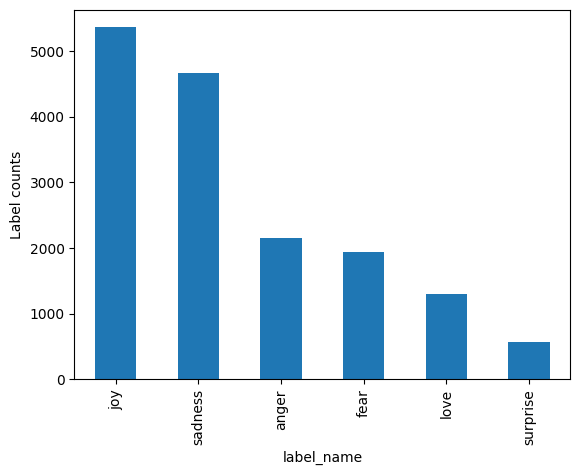

In [12]:
import matplotlib.pyplot as plt

df.label_name.value_counts().plot(kind='bar')
plt.ylabel("Label counts")
plt.show()

In [13]:
df['words_per_tweet'] = df.text.apply(lambda x: len(x.split()))
df.head(3)

,text,label,label_name,words_per_tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


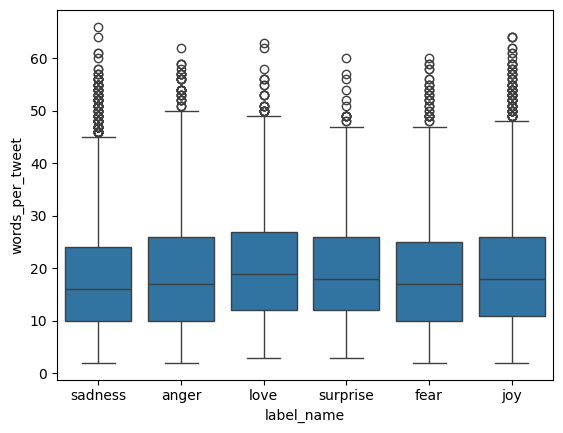

In [14]:
import seaborn as sns

sns.boxplot(data=df, x='label_name', y='words_per_tweet');

In [15]:
df.describe()

,label,words_per_tweet
count,15999.000000,15999.000000
mean,1.565973,19.166760
std,1.501471,10.987102
min,0.000000,2.000000
25%,0.000000,11.000000
50%,1.000000,17.000000
75%,3.000000,25.000000
max,5.000000,66.000000


In [16]:
from transformers import AutoTokenizer

model = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
text = "My name is Harsh Agarwal and I live in Mumbai. I love Software Engineering and Machine Learning. I am 25."
tokenizer.tokenize(text), len(tokenizer.tokenize(text))

(['my',
  'name',
  'is',
  'harsh',
  'ag',
  '##ar',
  '##wal',
  'and',
  'i',
  'live',
  'in',
  'mumbai',
  '.',
  'i',
  'love',
  'software',
  'engineering',
  'and',
  'machine',
  'learning',
  '.',
  'i',
  'am',
  '25',
  '.'],
 25)

In [18]:
tokenizer(text)

{'input_ids': [101, 2026, 2171, 2003, 8401, 12943, 2906, 13476, 1998, 1045, 2444, 1999, 8955, 1012, 1045, 2293, 4007, 3330, 1998, 3698, 4083, 1012, 1045, 2572, 2423, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [19]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.vocab_files_names, tokenizer.model_max_length

(30522,
 30522,
 {'vocab_file': 'vocab.txt', 'tokenizer_file': 'tokenizer.json'},
 512)

## Train-val-test split

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
val, test = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, val.shape, test.shape

((11199, 4), (3200, 4), (1600, 4))

## Datasets

In [21]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict({
    'train': Dataset.from_pandas(train, preserve_index=False),
    'test': Dataset.from_pandas(test, preserve_index=False),
    'validation': Dataset.from_pandas(val, preserve_index=False)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 11199
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 1600
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 3200
    })
})

In [22]:
dataset['train']

Dataset({
    features: ['text', 'label', 'label_name', 'words_per_tweet'],
    num_rows: 11199
})

In [23]:
dataset['train'][0]

{'text': 'hearing about developments of sience in the west a lot better than china',
 'label': 0,
 'label_name': 'sadness',
 'words_per_tweet': 13}

In [24]:
dataset['train']['text']

['hearing about developments of sience in the west a lot better than china',
 'i just grab something and hit myself just to feel pain damn i know the risks and injuries that might occur i know its dangerous',
 'i mean memories that make me feel dirty and unworthy',
 'i overhear the victory tune on some geeks ringtone i feel triumphant',
 'i feel so rude i thought as i dialed my house',
 'i am feeling thankful for warm sunshine crisp autumn air and bright fall colors',
 'i was so traumatised by the pestilence that i was feeling quite delicate and couldnt cook so we had to buy expensive and unhealthy convenience foods from the supermarket in order to avoid starvation',
 'i feel dull and easily all of the difference of the rule absolutely no i just can t several it so this in turn quick easy casserole is fantastic relating to group meals local hall pitch ins picnics address luncheons etc',
 'i feel have been convinced by many factors in our culture of a kind of cooking mystique',
 'i real

In [25]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

tokenize(dataset['train'][0])

{'input_ids': [101, 4994, 2055, 8973, 1997, 9033, 10127, 1999, 1996, 2225, 1037, 2843, 2488, 2084, 2859, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [26]:
tokenize(dataset['train'][:2])

{'input_ids': [[101, 4994, 2055, 8973, 1997, 9033, 10127, 1999, 1996, 2225, 1037, 2843, 2488, 2084, 2859, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2074, 6723, 2242, 1998, 2718, 2870, 2074, 2000, 2514, 3255, 4365, 1045, 2113, 1996, 10831, 1998, 6441, 2008, 2453, 5258, 1045, 2113, 2049, 4795, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [27]:
dt = dataset['train'].map(tokenize, batched=True, batch_size=None)
dt

Map:   0%|          | 0/11199 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11199
})

In [28]:
dt[0]

{'text': 'hearing about developments of sience in the west a lot better than china',
 'label': 0,
 'label_name': 'sadness',
 'words_per_tweet': 13,
 'input_ids': [101,
  4994,
  2055,
  8973,
  1997,
  9033,
  10127,
  1999,
  1996,
  2225,
  1037,
  2843,
  2488,
  2084,
  2859,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [29]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)
emotion_encoded

Map:   0%|          | 0/11199 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11199
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
})

In [30]:
id2label = {x['label']: x['label_name'] for x in dataset['train']}
label2id = {v: k for k, v in id2label.items()}

id2label, label2id

({0: 'sadness', 3: 'anger', 1: 'joy', 2: 'love', 4: 'fear', 5: 'surprise'},
 {'sadness': 0, 'anger': 3, 'joy': 1, 'love': 2, 'fear': 4, 'surprise': 5})

In [31]:
from transformers import AutoModel

model_name = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_name)

model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [32]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [33]:
model.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [34]:
model.encoder

BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSdpaSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [35]:
model.attn_implementation

'sdpa'

In [36]:
model.is_parallelizable, model.model_tags, model.position_embedding_type

(False, None, 'absolute')

In [37]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_name, id2label=id2label, label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)

device, config, model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(device(type='cuda'),
 BertConfig {
   "_name_or_path": "bert-base-uncased",
   "architectures": [
     "BertForMaskedLM"
   ],
   "attention_probs_dropout_prob": 0.1,
   "classifier_dropout": null,
   "gradient_checkpointing": false,
   "hidden_act": "gelu",
   "hidden_dropout_prob": 0.1,
   "hidden_size": 768,
   "id2label": {
     "0": "sadness",
     "1": "joy",
     "2": "love",
     "3": "anger",
     "4": "fear",
     "5": "surprise"
   },
   "initializer_range": 0.02,
   "intermediate_size": 3072,
   "label2id": {
     "anger": 3,
     "fear": 4,
     "joy": 1,
     "love": 2,
     "sadness": 0,
     "surprise": 5
   },
   "layer_norm_eps": 1e-12,
   "max_position_embeddings": 512,
   "model_type": "bert",
   "num_attention_heads": 12,
   "num_hidden_layers": 12,
   "pad_token_id": 0,
   "position_embedding_type": "absolute",
   "transformers_version": "4.44.2",
   "type_vocab_size": 2,
   "use_cache": true,
   "vocab_size": 30522
 },
 BertForSequenceClassification(
   (bert): 

In [39]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [40]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [41]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


In [42]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [48]:
from sklearn.metrics import f1_score, accuracy_score

def metrices(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(preds, labels, average='weighted')
  acc = accuracy_score(labels, preds)

  return {"f1-score": f1, "accuracy-score": acc}

In [49]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=metrices,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    tokenizer=tokenizer
)

In [50]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1-score,Accuracy-score
1,No log,0.216173,0.928999,0.928750
2,No log,0.197374,0.928798,0.928750


TrainOutput(global_step=350, training_loss=0.1130477033342634, metrics={'train_runtime': 350.6717, 'train_samples_per_second': 63.872, 'train_steps_per_second': 0.998, 'total_flos': 1001413001657736.0, 'train_loss': 0.1130477033342634, 'epoch': 2.0})

## Model Evaluation

In [51]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output

PredictionOutput(predictions=array([[-7.5835329e-01, -1.6867869e+00, -1.3111216e+00, -8.9735836e-01,
         5.4826593e+00, -7.7024150e-01],
       [-2.3451810e+00, -2.4281473e+00, -1.6335137e+00,  5.5233488e+00,
         1.1833332e+00, -4.5254204e-01],
       [ 6.4498234e+00, -1.5201906e+00, -1.3501494e+00, -1.2240981e+00,
        -1.1183892e+00, -1.5734185e+00],
       ...,
       [-1.2866905e+00, -1.4484099e+00, -1.8183123e+00, -1.4053271e+00,
         5.6193748e+00,  5.2507949e-01],
       [-1.1838377e+00,  6.3279896e+00, -4.6970155e-03, -1.8706355e+00,
        -1.4564295e+00, -9.0708721e-01],
       [ 6.4091907e+00, -1.5867482e+00, -1.4528511e+00, -1.1625029e+00,
        -9.2298907e-01, -1.6494592e+00]], dtype=float32), label_ids=array([4, 3, 0, ..., 4, 1, 0]), metrics={'test_loss': 0.20760950446128845, 'test_f1-score': 0.9193656551958211, 'test_accuracy-score': 0.919375, 'test_runtime': 6.2554, 'test_samples_per_second': 255.779, 'test_steps_per_second': 3.997})

In [54]:
preds_output.metrics

{'test_loss': 0.20760950446128845,
 'test_f1-score': 0.9193656551958211,
 'test_accuracy-score': 0.919375,
 'test_runtime': 6.2554,
 'test_samples_per_second': 255.779,
 'test_steps_per_second': 3.997}

In [56]:
preds_output.predictions

array([[-7.5835329e-01, -1.6867869e+00, -1.3111216e+00, -8.9735836e-01,
         5.4826593e+00, -7.7024150e-01],
       [-2.3451810e+00, -2.4281473e+00, -1.6335137e+00,  5.5233488e+00,
         1.1833332e+00, -4.5254204e-01],
       [ 6.4498234e+00, -1.5201906e+00, -1.3501494e+00, -1.2240981e+00,
        -1.1183892e+00, -1.5734185e+00],
       ...,
       [-1.2866905e+00, -1.4484099e+00, -1.8183123e+00, -1.4053271e+00,
         5.6193748e+00,  5.2507949e-01],
       [-1.1838377e+00,  6.3279896e+00, -4.6970155e-03, -1.8706355e+00,
        -1.4564295e+00, -9.0708721e-01],
       [ 6.4091907e+00, -1.5867482e+00, -1.4528511e+00, -1.1625029e+00,
        -9.2298907e-01, -1.6494592e+00]], dtype=float32)

In [63]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = emotion_encoded['test']['label']

In [64]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       467
           1       0.94      0.93      0.94       536
           2       0.81      0.81      0.81       130
           3       0.94      0.94      0.94       216
           4       0.90      0.86      0.88       194
           5       0.75      0.81      0.78        57

    accuracy                           0.92      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.92      0.92      0.92      1600



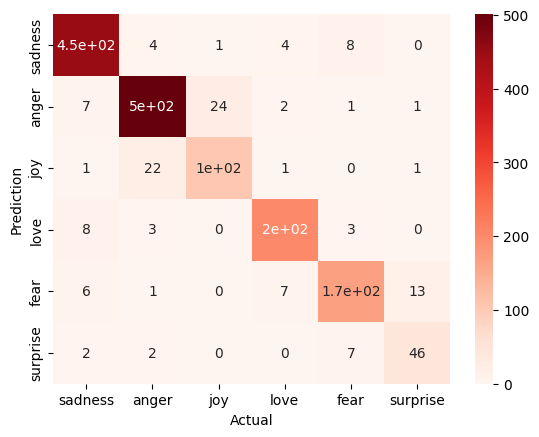

In [72]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=True, fmt='.2g', xticklabels=id2label.values(), yticklabels=id2label.values(), cmap='Reds')
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.show()

In [73]:
cm

array([[450,   4,   1,   4,   8,   0],
       [  7, 501,  24,   2,   1,   1],
       [  1,  22, 105,   1,   0,   1],
       [  8,   3,   0, 202,   3,   0],
       [  6,   1,   0,   7, 167,  13],
       [  2,   2,   0,   0,   7,  46]])

In [75]:
id2label

{0: 'sadness', 3: 'anger', 1: 'joy', 2: 'love', 4: 'fear', 5: 'surprise'}

## Building prediction function and storing model

In [79]:
text = "the geopolitics of middle-east is getting insane. we can see these impacting trades, oil prices and international relations"
input_encoded=tokenizer(text, return_tensors='pt').to(device)
input_encoded

{'input_ids': tensor([[  101,  1996, 20248, 18155, 18291,  2015,  1997,  2690,  1011,  2264,
          2003,  2893,  9577,  1012,  2057,  2064,  2156,  2122,  4254,  2075,
         14279,  1010,  3514,  7597,  1998,  2248,  4262,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]], device='cuda:0')}

In [80]:
with torch.no_grad():
  outputs = model(**input_encoded)

outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.2639, -1.3518, -2.6708,  3.2144,  2.2854, -1.3040]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [86]:
outputs.logits[0]

tensor([-0.2639, -1.3518, -2.6708,  3.2144,  2.2854, -1.3040], device='cuda:0')

In [88]:
torch.argmax(outputs.logits, axis=1)

tensor([3], device='cuda:0')

In [98]:
id2label[torch.argmax(outputs.logits, axis=1).item()]

'anger'

In [103]:
def generate_prediction(text):
  input_encoder = tokenizer(text, return_tensors='pt').to(device)
  with torch.no_grad():
    outputs = model(**input_encoder)
  return id2label[torch.argmax(outputs.logits, axis=1).item()]

generate_prediction(text)

'anger'

In [104]:
trainer.save_model("bert-sentiment-classification-model")

In [108]:
from transformers import pipeline

classifier = pipeline("text-classification", model="bert-sentiment-classification-model")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [109]:
classifier([text, "hey, how you doing?", "he's a madman"])

[{'label': 'anger', 'score': 0.6897017955780029},
 {'label': 'joy', 'score': 0.9867096543312073},
 {'label': 'anger', 'score': 0.9568170309066772}]